## Introduction

The purpose of this project is to build a machine learning model which uses data from https://moneypuck.com and, intuitively, attempts to learn how many goals a player "deserved" to score in a given season. This is in order to perform outlier detection. An "underperforming" player is a player who scored significantly less goals than the model predicted they should score, and an "overperforming" player would be a player who scored more goals than the model predicted. 

It is important to note that this model is not predicting how many goals a player will score *next* season. Instead, the model is learning how many goals a player *should have scored this season*, and comparing this prediction with the number of goals the player *actually* scored. 

From this, we will see that most players who are deemed as underperformers by the model do indeed have bounce back seasons (purely in terms of number of goals scored) the following year, and similarly most overperformers tend to score less goals the following year.

This type of model might be useful tool when trying to evaluate, say, the value of a player in a trade (e.g. selling high and buying low), negotiating contracts, or creating draft lists.

## Imports

In [4]:
import os

import csv
%matplotlib inline
import sys

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
#import eli5
#import shap
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import (
    accuracy_score,
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
    recall_score,
    mean_absolute_error
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR

In [5]:
# Load the data from each year into a dictionary
dfs = {}
for i in np.arange(10,22):
    year = str(i)+"_"+str(i+1)
    csv_name = "Players_"+year+".csv"
    dfs[year] = pd.read_csv(csv_name, index_col="playerId")

## Exploratory Data Analysis

In [7]:
## Import the data dictionary which describes the data
#with open("MoneyPuckDataDictionaryForPlayers.csv", newline='') as csvfile:
#    r = csv.reader(csvfile, delimiter=',', quotechar='|')
#    for row in r:
#        print(''.join(row))

In [8]:
# Descriptions of the features

pd.set_option('display.max_colwidth', None, "display.max_rows", None)
explanations = pd.read_csv("MoneyPuckDataDictionaryForPlayers.csv").drop(labels=range(25),axis=0)
renamed = {"*****MoneyPuck.com Player and Team Data******":"Column Name",
          "Unnamed: 1":"Description"}
explanations = explanations.rename(mapper=renamed, axis=1)
#explanations

In [232]:
dfs["17_18"].head(5)

,season,name,team,position,situation,games_played,icetime,shifts,gameScore,onIce_xGoalsPercentage,offIce_xGoalsPercentage,onIce_corsiPercentage,offIce_corsiPercentage,onIce_fenwickPercentage,offIce_fenwickPercentage,iceTimeRank,I_F_xOnGoal,I_F_xGoals,I_F_xRebounds,I_F_xFreeze,I_F_xPlayStopped,I_F_xPlayContinuedInZone,I_F_xPlayContinuedOutsideZone,I_F_flurryAdjustedxGoals,I_F_scoreVenueAdjustedxGoals,I_F_flurryScoreVenueAdjustedxGoals,I_F_primaryAssists,I_F_secondaryAssists,I_F_shotsOnGoal,I_F_missedShots,I_F_blockedShotAttempts,I_F_shotAttempts,I_F_points,I_F_goals,I_F_rebounds,I_F_reboundGoals,I_F_freeze,I_F_playStopped,I_F_playContinuedInZone,I_F_playContinuedOutsideZone,...,OnIce_A_xOnGoal,OnIce_A_xGoals,OnIce_A_flurryAdjustedxGoals,OnIce_A_scoreVenueAdjustedxGoals,OnIce_A_flurryScoreVenueAdjustedxGoals,OnIce_A_shotsOnGoal,OnIce_A_missedShots,OnIce_A_blockedShotAttempts,OnIce_A_shotAttempts,OnIce_A_goals,OnIce_A_rebounds,OnIce_A_reboundGoals,OnIce_A_lowDangerShots,OnIce_A_mediumDangerShots,OnIce_A_highDangerShots,OnIce_A_lowDangerxGoals,OnIce_A_mediumDangerxGoals,OnIce_A_highDangerxGoals,OnIce_A_lowDangerGoals,OnIce_A_mediumDangerGoals,OnIce_A_highDangerGoals,OnIce_A_scoreAdjustedShotsAttempts,OnIce_A_unblockedShotAttempts,OnIce_A_scoreAdjustedUnblockedShotAttempts,OnIce_A_xGoalsFromxReboundsOfShots,OnIce_A_xGoalsFromActualReboundsOfShots,OnIce_A_reboundxGoals,OnIce_A_xGoals_with_earned_rebounds,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_A_xGoals_with_earned_rebounds_scoreFlurryAdjusted,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts
playerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8479595,2017,Blake Hillman,CHI,D,other,4,70.0,2.0,-0.13,0.00,0.25,0.00,0.44,0.00,0.33,7.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.70,0.03,0.03,0.03,0.03,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.03,0.00,0.00,0.0,0.0,0.0,1.00,1.0,1.00,0.01,0.0,0.0,0.03,0.03,0.03,0.18,0.55,4.0,5.0,0.00,0.00,0.0,0.0,0.0,0.0
8479595,2017,Blake Hillman,CHI,D,all,4,4327.0,99.0,0.12,0.32,0.37,0.36,0.45,0.39,0.44,19.0,4.67,0.07,0.23,1.20,0.14,2.83,2.53,0.07,0.07,0.07,0.0,0.0,5.0,2.0,3.0,10.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,...,40.65,3.48,3.34,3.55,3.40,38.0,22.0,27.0,87.0,2.0,4.0,0.0,47.0,10.0,3.0,1.66,1.14,0.68,1.0,1.0,0.0,90.86,60.0,61.81,0.68,0.7,0.7,3.46,3.49,3.41,5.12,8.86,153.0,185.0,0.00,0.00,0.0,0.0,0.0,0.0
8479595,2017,Blake Hillman,CHI,D,5on5,4,3860.0,84.0,0.12,0.37,0.38,0.41,0.47,0.45,0.46,19.0,3.94,0.05,0.21,1.07,0.12,2.63,1.91,0.05,0.05,0.05,0.0,0.0,4.0,2.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,...,31.94,2.78,2.68,2.85,2.75,33.0,14.0,24.0,71.0,2.0,4.0,0.0,37.0,7.0,3.0,1.28,0.82,0.68,1.0,1.0,0.0,74.86,47.0,48.81,0.46,0.7,0.7,2.55,2.57,2.55,4.37,6.99,138.0,157.0,0.09,0.14,4.0,4.0,2.0,3.0
8479595,2017,Blake Hillman,CHI,D,4on5,4,392.0,12.0,0.12,0.02,0.01,0.06,0.06,0.08,0.08,11.0,0.73,0.01,0.02,0.13,0.02,0.20,0.62,0.01,0.01,0.01,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.01,0.67,0.63,0.67,0.63,4.0,8.0,3.0,15.0,0.0,0.0,0.0,9.0,3.0,0.0,0.35,0.32,0.00,0.0,0.0,0.0,15.00,12.0,12.00,0.21,0.0,0.0,0.88,0.88,0.83,0.01,1.06,1.0,17.0,0.00,0.00,0.0,0.0,0.0,0.0
8479595,2017,Blake Hillman,CHI,D,5on4,4,5.0,1.0,0.03,0.00,0.08,0.00,0.25,0.00,0.33,5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.01,0.16,1.0,3.0,0.00,0.00,0.0,0.0,0.0,0.0


In [10]:
#dfs["17_18"].columns.tolist()

##### *Note:*
There are 153 of features here. Some of them we need to be careful with. 

For example, the saved shots on goal feature must be dropped. The model scored extremely well on predicting goals, and upon further inspection, the largest positive coefficient identified by Ridge was shots on goal, while the largest negative coefficient was saved shots on goal. So the model essentially had learned something along the lines of goals = shots - saves shots, which means we were essentially giving it the answers.

In [233]:
dfs["17_18"]["position"].value_counts()

D    1530
C    1365
L     860
R     695
Name: position, dtype: int64

In [236]:
# Create a dataframe for all-situations scoring (as opposed to just 5 on 5, or 5 on 4, etc)
for key in dfs.keys():
    dfs[key] = dfs[key].loc[dfs[key]["situation"] == "all"].drop(columns="situation")

In [13]:
#set back to default
pd.set_option('display.max_colwidth', 50, "display.max_rows", 60)

## Predicting Goals per Game

### Split the Data

In [238]:
X_all_years = [dfs[key].drop(columns="I_F_goals") for key in dfs.keys()]
y_all_years = [dfs[key]["I_F_goals"] for key in dfs.keys()]

In [243]:
def CreateXytrain(season_start="10_11", season_end="16_17"):
    
    start = int(season_start[:2])
    finish = int(season_end[:2])
    
    X = []
    y = []
    
    for i in np.arange(start,finish+1):
        
        dfX = X_all_years[i-start]
        
        playerid_new = {playerid: str(playerid)+"_"+str(i)+"_"+str(i+1) for playerid in list(dfX.index)}
        dfX = dfX.rename(index=playerid_new)
        X.append(dfX)
        
        dfy = y_all_years[i-start]
        dfy = dfy.rename(index=playerid_new)
        y.append(dfy)
        
        
    return pd.concat(X), pd.concat(y)

In [327]:
# Seasons used as training data (i.e. "previous seaons")
season_start = "10_11"
season_end = "16_17"
X_train, y_train = CreateXytrain(season_start, season_end)

# Seasons used for predicting over/underperformers (i.e. "this year" and "next year")
this_season = "17_18"
next_season = "18_19"

playerid_this_season = {playerid: str(playerid)+"_"+this_season for playerid in list(dfs[this_season].index)}
X_this_season = dfs[this_season].drop(columns="I_F_goals").rename(index=playerid_this_season)
y_this_season = dfs[this_season]["I_F_goals"].rename(index=playerid_this_season)

playerid_next_season = {playerid: str(playerid)+"_"+next_season for playerid in list(dfs[next_season].index)}
X_next_season = dfs[next_season].drop(columns="I_F_goals").rename(index=playerid_next_season)
y_next_season = dfs[next_season]["I_F_goals"].rename(index=playerid_next_season)

In [263]:
X_next_season.head()

,season,name,team,position,games_played,icetime,shifts,gameScore,onIce_xGoalsPercentage,offIce_xGoalsPercentage,onIce_corsiPercentage,offIce_corsiPercentage,onIce_fenwickPercentage,offIce_fenwickPercentage,iceTimeRank,I_F_xOnGoal,I_F_xGoals,I_F_xRebounds,I_F_xFreeze,I_F_xPlayStopped,I_F_xPlayContinuedInZone,I_F_xPlayContinuedOutsideZone,I_F_flurryAdjustedxGoals,I_F_scoreVenueAdjustedxGoals,I_F_flurryScoreVenueAdjustedxGoals,I_F_primaryAssists,I_F_secondaryAssists,I_F_shotsOnGoal,I_F_missedShots,I_F_blockedShotAttempts,I_F_shotAttempts,I_F_points,I_F_rebounds,I_F_reboundGoals,I_F_freeze,I_F_playStopped,I_F_playContinuedInZone,I_F_playContinuedOutsideZone,I_F_savedShotsOnGoal,I_F_savedUnblockedShotAttempts,...,OnIce_A_xOnGoal,OnIce_A_xGoals,OnIce_A_flurryAdjustedxGoals,OnIce_A_scoreVenueAdjustedxGoals,OnIce_A_flurryScoreVenueAdjustedxGoals,OnIce_A_shotsOnGoal,OnIce_A_missedShots,OnIce_A_blockedShotAttempts,OnIce_A_shotAttempts,OnIce_A_goals,OnIce_A_rebounds,OnIce_A_reboundGoals,OnIce_A_lowDangerShots,OnIce_A_mediumDangerShots,OnIce_A_highDangerShots,OnIce_A_lowDangerxGoals,OnIce_A_mediumDangerxGoals,OnIce_A_highDangerxGoals,OnIce_A_lowDangerGoals,OnIce_A_mediumDangerGoals,OnIce_A_highDangerGoals,OnIce_A_scoreAdjustedShotsAttempts,OnIce_A_unblockedShotAttempts,OnIce_A_scoreAdjustedUnblockedShotAttempts,OnIce_A_xGoalsFromxReboundsOfShots,OnIce_A_xGoalsFromActualReboundsOfShots,OnIce_A_reboundxGoals,OnIce_A_xGoals_with_earned_rebounds,OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted,OnIce_A_xGoals_with_earned_rebounds_scoreFlurryAdjusted,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts
playerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8478474_18_19,2018,Lawson Crouse,ARI,L,81,63012.0,1604.0,20.59,0.46,0.52,0.43,0.51,0.45,0.51,707.0,131.08,12.66,8.89,31.52,4.50,69.70,54.79,12.08,12.64,12.05,11.0,3.0,131.0,52.0,31.0,214.0,25.0,11.0,1.0,26.0,9.0,61.0,65.0,120.0,172.0,...,588.89,47.78,45.94,47.53,45.71,576.0,260.0,339.0,1175.0,43.0,44.0,9.0,656.0,147.0,33.0,17.41,18.38,12.00,11.0,20.0,12.0,1169.60,836.0,833.47,8.81,8.81,8.87,47.67,47.41,46.50,188.03,174.31,3783.0,3595.0,0.0,0.0,0.0,0.0,0.0,0.0
8480950_18_19,2018,Ilya Lyubushkin,ARI,D,41,33673.0,768.0,2.98,0.48,0.53,0.46,0.50,0.47,0.50,242.0,30.90,1.29,1.83,9.04,1.09,18.32,14.43,1.25,1.25,1.21,3.0,1.0,27.0,19.0,18.0,64.0,4.0,3.0,0.0,10.0,1.0,15.0,17.0,27.0,46.0,...,289.80,22.32,21.87,22.63,22.17,291.0,117.0,158.0,566.0,25.0,17.0,2.0,319.0,72.0,17.0,9.28,8.48,4.57,13.0,9.0,3.0,567.35,408.0,410.12,4.07,2.97,2.97,23.42,23.72,23.44,97.20,87.22,1875.0,1889.0,0.0,0.0,0.0,0.0,0.0,0.0
8480955_18_19,2018,Bogdan Kiselevich,FLA,D,32,28512.0,627.0,7.85,0.51,0.49,0.51,0.53,0.51,0.53,166.0,14.52,0.51,0.92,4.05,0.51,9.43,7.58,0.50,0.52,0.51,6.0,2.0,14.0,9.0,19.0,42.0,8.0,0.0,0.0,4.0,1.0,8.0,10.0,14.0,23.0,...,214.38,15.79,15.41,15.85,15.46,225.0,82.0,110.0,417.0,18.0,16.0,2.0,245.0,50.0,12.0,6.63,5.69,3.47,7.0,7.0,4.0,419.43,307.0,308.89,2.87,3.28,3.28,15.38,15.46,15.25,72.30,76.53,1461.0,1309.0,0.0,0.0,0.0,0.0,0.0,0.0
8479365_18_19,2018,Trent Frederic,BOS,C,15,8411.0,197.0,0.73,0.43,0.53,0.49,0.52,0.47,0.53,172.0,16.03,1.41,1.07,3.98,0.51,8.23,6.81,1.34,1.42,1.36,0.0,0.0,19.0,3.0,2.0,24.0,0.0,2.0,0.0,5.0,0.0,6.0,9.0,19.0,22.0,...,63.07,4.95,4.83,4.81,4.70,67.0,22.0,32.0,121.0,5.0,5.0,2.0,70.0,14.0,5.0,1.85,1.70,1.40,1.0,2.0,2.0,118.68,89.0,87.08,0.81,0.89,0.89,4.87,4.75,4.67,39.86,35.71,753.0,698.0,0.0,0.0,0.0,0.0,0.0,0.0
8479318_18_19,2018,Auston Matthews,TOR,C,68,75671.0,1591.0,80.75,0.58,0.50,0.59,0.50,0.58,0.48,207.0,263.51,30.55,19.85,56.39,8.55,145.73,99.95,28.86,30.92,29.18,23.0,13.0,252.0,109.0,88.0,449.0,73.0,19.0,7.0,58.0,10.0,127.0,110.0,215.0,324.0,...,646.14,62.96,59.89,63.35,60.25,656.0,248.0,262.0,1166.0,70.0,53.0,13.0,677.0,166.0,61.0,21.53,20.46,20.96,25.0,26.0,19.0,1170.00,904.0,9

# Create a preprocessor

In [ ]:
X_train.columns.tolist()

In [267]:
drop_features = ["season", "name", "I_F_primaryAssists", "I_F_secondaryAssists",
               'I_F_points', 'I_F_reboundGoals', 
               'I_F_lowDangerGoals', 'I_F_mediumDangerGoals', 'I_F_highDangerGoals', 
               'OnIce_F_goals', 'OnIce_F_reboundGoals',
               'OnIce_F_lowDangerGoals', 'OnIce_F_mediumDangerGoals', 'OnIce_F_highDangerGoals', 
                "I_F_savedShotsOnGoal", "I_F_savedUnblockedShotAttempts"]


# get rid of all "on ice against" statistics
#one_ice_a = []
for feat in X_train.columns.tolist():
    if feat[:7] == "OnIce_A":
        drop_features.append(feat) 
    

categorical_features = ["team", "position"]

pass_features = X_train.columns.tolist()
for feat in drop_features + categorical_features: #everything else is passed through
    pass_features.remove(feat)
        
# Create a column transformer
preprocessor = make_column_transformer((OneHotEncoder(handle_unknown = "ignore"), categorical_features),
                                       ("passthrough", pass_features),
                                       ("drop", drop_features))

# Note that we will apply standard scaler later in a pipeline

# Keep track of new feature names
new_categorical_features = []
for feat_name in X_train["team"].unique().tolist() + X_train["position"].unique().tolist():
    new_categorical_features.append(feat_name)

new_feature_names = new_categorical_features + pass_features

### Some Careful Feature Selection

In [268]:
num_features = ['games_played', 'icetime', 
                'gameScore', 
                'onIce_corsiPercentage', 'onIce_fenwickPercentage', 
                'I_F_primaryAssists', 'I_F_secondaryAssists', #
                'I_F_shotsOnGoal', 'I_F_missedShots', 'I_F_blockedShotAttempts', 'I_F_shotAttempts', 
                'I_F_rebounds', 'I_F_freeze', 'I_F_playStopped', 
                'I_F_playContinuedInZone', 'I_F_playContinuedOutsideZone',  
                'I_F_hits', 'I_F_takeaways', 'I_F_giveaways', 'I_F_lowDangerShots', 'I_F_mediumDangerShots', 
                'I_F_highDangerShots', 'I_F_scoreAdjustedShotsAttempts', 'I_F_unblockedShotAttempts', #
                'I_F_shifts', 
                'I_F_oZoneShiftStarts', 'I_F_dZoneShiftStarts', 'I_F_neutralZoneShiftStarts', 
                'I_F_flyShiftStarts', 'I_F_oZoneShiftEnds', 'I_F_dZoneShiftEnds', 'I_F_neutralZoneShiftEnds', 
                'I_F_flyShiftEnds', 'faceoffsWon', 'faceoffsLost', 
                'penalityMinutesDrawn', 'penaltiesDrawn', 'OnIce_F_shotsOnGoal', 'OnIce_F_missedShots', #
                'OnIce_F_blockedShotAttempts', 'OnIce_F_shotAttempts', 'OnIce_F_rebounds', 
                'OnIce_F_lowDangerShots', 'OnIce_F_mediumDangerShots', 
                'OnIce_F_highDangerShots', 
                'OnIce_F_unblockedShotAttempts', 'corsiForAfterShifts', 
                'corsiAgainstAfterShifts', 'fenwickForAfterShifts', 'fenwickAgainstAfterShifts']

categorical_features = ['team', 'position']
drop_features = []
for feat in X_17_18.columns:
    if feat not in num_features+categorical_features:
        drop_features.append(feat)
        
preprocessor = make_column_transformer((OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features),
                                       (StandardScaler(), num_features),
                                       ("drop", drop_features))

In [269]:
X_train_transformed = preprocessor.fit_transform(X_train)

ohe_column_names = preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist()#[0:51]

new_feature_names = ohe_column_names + num_features

pd.DataFrame(X_train_transformed, columns = new_feature_names).head()

,team_ANA,team_ARI,team_ATL,team_BOS,team_BUF,team_CAR,team_CBJ,team_CGY,team_CHI,team_COL,team_DAL,team_DET,team_EDM,team_FLA,team_L.A,team_MIN,team_MTL,team_N.J,team_NSH,team_NYI,team_NYR,team_OTT,team_PHI,team_PIT,team_S.J,team_STL,team_T.B,team_TOR,team_VAN,team_WPG,team_WSH,position_C,position_D,position_L,position_R,games_played,icetime,gameScore,onIce_corsiPercentage,onIce_fenwickPercentage,...,I_F_shotAttempts,I_F_rebounds,I_F_freeze,I_F_playStopped,I_F_playContinuedInZone,I_F_playContinuedOutsideZone,I_F_hits,I_F_takeaways,I_F_giveaways,I_F_lowDangerShots,I_F_mediumDangerShots,I_F_highDangerShots,I_F_scoreAdjustedShotsAttempts,I_F_unblockedShotAttempts,I_F_shifts,I_F_oZoneShiftStarts,I_F_dZoneShiftStarts,I_F_neutralZoneShiftStarts,I_F_flyShiftStarts,I_F_oZoneShiftEnds,I_F_dZoneShiftEnds,I_F_neutralZoneShiftEnds,I_F_flyShiftEnds,faceoffsWon,faceoffsLost,penalityMinutesDrawn,penaltiesDrawn,OnIce_F_shotsOnGoal,OnIce_F_missedShots,OnIce_F_blockedShotAttempts,OnIce_F_shotAttempts,OnIce_F_rebounds,OnIce_F_lowDangerShots,OnIce_F_mediumDangerShots,OnIce_F_highDangerShots,OnIce_F_unblockedShotAttempts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.838462,0.851460,1.281889,-0.034918,0.096867,...,0.865052,1.017967,1.116542,0.089568,1.047915,0.879748,-0.678719,2.942530,0.680218,0.838270,1.156981,0.803290,0.872169,0.981708,0.939477,0.773254,1.768455,1.148517,0.596470,1.109177,0.442247,0.906088,0.997557,2.087563,2.641009,1.254200,1.675328,0.807122,0.872760,0.759272,0.812203,0.702240,0.737278,1.089542,0.990579,0.828122,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.416111,0.629015,0.026369,0.091290,0.096867,...,0.196519,-0.610950,-0.010328,-0.573418,0.043902,0.083490,0.002423,0.752979,1.837946,0.205823,-0.653787,-0.801512,0.189530,-0.074032,0.706164,0.056114,0.574063,0.398008,0.980940,0.598709,0.785377,0.395594,0.781414,-0.442872,-0.467527,0.266631,0.167358,0.672918,0.607821,0.738814,0.678979,0.356376,0.771973,0.430874,-0.037003,0.656378,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.908854,0.819055,0.559238,0.469915,0.346907,...,1.079937,-0.429959,1.742581,0.089568,1.307015,1.192564,0.862813,0.327233,-0.003893,1.091248,1.545003,0.432951,1.054608,1.235085,0.918395,1.302572,0.199180,1.236342,0.833861,0.272010,1.128507,0.914596,0.997557,-0.238622,-0.084201,0.360685,0.167358,0.682738,0.789967,0.643345,0.698262,0.572541,0.642654,0.869986,0.990579,0.715194,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.921332,-0.650923,-0.747537,0.091290,0.221887,...,-0.583436,-0.067978,-0.511159,-0.904910,-0.668624,-0.599017,-0.589095,-0.706721,-0.688005,-0.496895,-0.783128,-0.801512,-0.586712,-0.633574,-0.658577,-0.584189,-0.559302,-0.600010,-0.673055,-0.667251,-0.722315,-0.557326,-0.651448,-0.442872,-0.467527,-0.579856,-0.528628,-0.528373,-0.749995,-0.775058,-0.640987,-0.075953,-0.584303,-0.654709,-0.448036,-0.592884,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.084833,0.757397,0.863998,0.848540,0.721968,...,0.506909,0.113013,0.553107,0.752554,1.145078,0.168804,-0.087201,1.543650,0.469722,0.304204,1.113867,1.420522,0.481862,0.622756,0.724436,1.430633,0.216617,0.789230,0.578408,1.027502,0.754183,0.701890,0.630842,-0.425851,-0.419611,-0.109585,0.051360,0.993698,1.013509,1.195704,1.054109,0.745473,0.939142,1.174925,1.093337,1.002219,0.0,0.0,0.0,0.0


### Create a Pipeline for Multiple Models

In [270]:
# Ridge regression
pipe_Ridge = make_pipeline(preprocessor, StandardScaler(), Ridge())

# Lasso Regression
pipe_Lasso = make_pipeline(preprocessor, StandardScaler(), Lasso(max_iter=1000))

# Random forest regression
pipe_rfr = make_pipeline(preprocessor, RandomForestRegressor())

# SVM Regression
# Unfortunately my laptop is too slow to do hyperparameter optimization on svr but it is still giving
# decent results with a regularization strength of 1 and Gaussian RBF kernel
pipe_svr = make_pipeline(preprocessor, StandardScaler(), SVR(kernel="rbf", C=1.0))

### Hyperparameter Tuning - Support Vector Regressor

In [271]:
pipe_svr = make_pipeline(preprocessor, StandardScaler(), SVR(kernel="rbf", C=1))
pd.DataFrame(cross_validate(pipe_svr, X_train, np.ravel(y_train), scoring="neg_mean_absolute_error"))

,fit_time,score_time,test_score
0,1.966912,0.608294,-1.904484
1,2.037252,0.625270,-1.524822
2,2.030325,0.650089,-1.691228
3,2.073650,0.623667,-1.805595
4,2.074008,0.631766,-1.865905


### Hyperparameter Tuning - Ridge

In [272]:
# Ridge 
parameters_ridge = {"ridge__alpha": np.linspace(0.001, 5, 100)} # Some values for the regularization strength
gs_ridge = GridSearchCV(
                            pipe_Ridge, 
                            parameters_ridge,
                            scoring="neg_mean_absolute_error"
)
# I have an older laptop that doesn't take well to parallel processing so n_jobs is not -1 here for grid search! 

gs_ridge.fit(X_train, y_train);

In [273]:
alpha_best_ridge = gs_ridge.best_params_["ridge__alpha"]
alpha_best_ridge

0.001

In [274]:
pd.DataFrame(gs_ridge.cv_results_).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.048361,0.018034,0.016550,0.006254,0.001,{'ridge__alpha': 0.001},-0.008308,-0.007013,-0.005784,-0.006854,-0.006711,-0.006934,0.000809,1
1,0.062361,0.021222,0.015991,0.004705,0.0514949,{'ridge__alpha': 0.05149494949494949},-0.020857,-0.018648,-0.020060,-0.022664,-0.022150,-0.020876,0.001446,2
2,0.054957,0.017327,0.015707,0.005855,0.10199,{'ridge__alpha': 0.10198989898989898},-0.035771,-0.032202,-0.035924,-0.039568,-0.038984,-0.036490,0.002643,3
3,0.075889,0.015674,0.017647,0.004813,0.152485,{'ridge__alpha': 0.15248484848484847},-0.050224,-0.045151,-0.051109,-0.055835,-0.055044,-0.051473,0.003833,4
4,0.056982,0.020047,0.015643,0.005355,0.20298,{'ridge__alpha': 0.20297979797979795},-0.064133,-0.057511,-0.065650,-0.071480,-0.070388,-0.065832,0.004996,5


In [275]:
pipe_Ridge = make_pipeline(preprocessor, StandardScaler(), Ridge(alpha=alpha_best_ridge))
pd.DataFrame(cross_validate(pipe_Ridge, X_train, y_train, scoring="neg_mean_absolute_error"))

,fit_time,score_time,test_score
0,0.048789,0.024016,-0.008308
1,0.093286,0.024463,-0.007013
2,0.108426,0.046614,-0.005784
3,0.106431,0.011563,-0.006854
4,0.058668,0.014338,-0.006711


In [276]:
pipe_Ridge.fit(X_train, y_train)
new_feature_names[np.argmax(pipe_Ridge.named_steps["ridge"].coef_)]

'I_F_shotsOnGoal'

In [277]:
new_feature_names[np.argmin(pipe_Ridge.named_steps["ridge"].coef_)]

'I_F_playContinuedOutsideZone'

In [ ]:
sorted_coefs = np.sort(np.array(pipe_Ridge.named_steps["ridge"].coef_))
locs = np.argsort(np.array(pipe_Ridge.named_steps["ridge"].coef_))
for i, coef in enumerate(sorted_coefs):
    print(i)
    print("Feature:", new_feature_names[locs[i]])
    print("Coefficient:", coef)
    print("\n")

### Hyperparameter Tuning - Lasso

In [281]:
# Lasso 
parameters_lasso = {"lasso__alpha": np.linspace(0.1, 5, 100)} # Some values for the regularization strength
gs_lasso = GridSearchCV(
                            pipe_Lasso, 
                            parameters_lasso,
                            scoring="neg_mean_absolute_error"
)
# I have an older laptop that doesn't take well to parallel processing so n_jobs is not -1 here for grid search! 

gs_lasso.fit(X_train, y_train);

In [282]:
alpha_best_lasso = gs_lasso.best_params_["lasso__alpha"]
alpha_best_lasso

0.1

In [283]:
pd.DataFrame(gs_lasso.cv_results_).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.098382,0.020037,0.013195,0.001555,0.1,{'lasso__alpha': 0.1},-1.703384,-1.455382,-1.640864,-1.777717,-1.766966,-1.668863,0.117493,1
1,0.078869,0.020218,0.016456,0.003755,0.149495,{'lasso__alpha': 0.14949494949494951},-1.745847,-1.499402,-1.683060,-1.819675,-1.809318,-1.711460,0.116828,2
2,0.071256,0.010634,0.014032,0.004728,0.19899,{'lasso__alpha': 0.198989898989899},-1.755717,-1.509445,-1.687049,-1.818354,-1.813354,-1.716784,0.114045,7
3,0.082890,0.015244,0.019168,0.006293,0.248485,{'lasso__alpha': 0.2484848484848485},-1.756065,-1.507656,-1.685330,-1.814520,-1.810205,-1.714755,0.113601,5
4,0.065998,0.021962,0.013748,0.004102,0.29798,{'lasso__alpha': 0.297979797979798},-1.757857,-1.504476,-1.684012,-1.810138,-1.808622,-1.713021,0.113942,3


In [284]:
pipe_Lasso = make_pipeline(preprocessor, StandardScaler(), Lasso(alpha = alpha_best_lasso))
pd.DataFrame(cross_validate(pipe_Lasso, X_train, y_train, scoring="neg_mean_absolute_error"))

,fit_time,score_time,test_score
0,0.078665,0.016224,-1.703384
1,0.089944,0.011931,-1.455382
2,0.125999,0.016001,-1.640864
3,0.119791,0.013131,-1.777717
4,0.073990,0.011834,-1.766966


In [285]:
pipe_Lasso.fit(X_train, y_train)
new_feature_names[np.argmax(pipe_Lasso.named_steps["lasso"].coef_)]

'gameScore'

In [286]:
new_feature_names[np.argmin(pipe_Lasso.named_steps["lasso"].coef_)]

'I_F_oZoneShiftEnds'

In [ ]:
sorted_coefs = np.sort(np.array(pipe_Lasso.named_steps["lasso"].coef_))
locs = np.argsort(np.array(pipe_Lasso.named_steps["lasso"].coef_))
for i, coef in enumerate(sorted_coefs):
    print(i)
    print("Feature:", new_feature_names[locs[i]])
    print("Coefficient:", coef)
    print("\n")

### Hyperparameter Tuning - Random Forest

In [288]:
# Random Forest 
d = preprocessor.fit_transform(X_train).shape[1]
parameters_rfr = {
                    "randomforestregressor__max_depth": np.arange(np.floor(np.sqrt(d)/2), np.floor(np.sqrt(d)*2)),
                    "randomforestregressor__n_estimators": np.arange(20,100)
                 }
                  #Some values for the regularization strength
rs_rfr = RandomizedSearchCV(
                            pipe_rfr, 
                            parameters_rfr,
                            scoring = "neg_mean_absolute_error",
                            n_jobs=-1
)

rs_rfr.fit(X_train, np.ravel(y_train));

In [289]:
max_depth_best = rs_rfr.best_params_["randomforestregressor__max_depth"]
n_estimators_best = rs_rfr.best_params_["randomforestregressor__n_estimators"]

print(max_depth_best)
print(n_estimators_best)

11.0
95


In [290]:
pd.DataFrame(rs_rfr.cv_results_).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__n_estimators,param_randomforestregressor__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.014899,0.029832,0.028029,0.005799,32,13,"{'randomforestregressor__n_estimators': 32, 'r...",-1.698499,-1.431419,-1.591147,-1.759157,-1.731794,-1.642403,0.119925,7
1,7.013183,0.012005,0.029778,0.000435,54,10,"{'randomforestregressor__n_estimators': 54, 'r...",-1.670117,-1.473732,-1.563214,-1.747679,-1.721932,-1.635335,0.102613,6
2,4.333304,0.035561,0.029604,0.004861,63,5,"{'randomforestregressor__n_estimators': 63, 'r...",-1.800726,-1.549766,-1.646153,-1.861212,-1.809357,-1.733443,0.116594,10
3,6.744900,0.035560,0.034929,0.001096,98,5,"{'randomforestregressor__n_estimators': 98, 'r...",-1.796442,-1.549393,-1.648390,-1.841433,-1.814114,-1.729954,0.112415,9
4,13.307637,0.036258,0.046536,0.002030,95,11,"{'randomforestregressor__n_estimators': 95, 'r...",-1.682580,-1.438571,-1.554116,-1.760915,-1.715165,-1.630269,0.117949,1


In [291]:
pipe_rfr = make_pipeline(preprocessor, 
                                 StandardScaler(), 
                                 RandomForestRegressor(max_depth = max_depth_best, n_estimators = n_estimators_best)
                                )
pd.DataFrame(cross_validate(pipe_rfr, 
                            X_train, 
                            np.ravel(y_train), 
                            scoring="neg_mean_absolute_error"))

,fit_time,score_time,test_score
0,8.990809,0.035238,-1.674319
1,9.034735,0.032846,-1.442152
2,8.981962,0.033882,-1.566573
3,9.304772,0.033956,-1.745795
4,9.034213,0.032966,-1.716513


### Stacking Model

In [292]:
sr_ridge = StackingRegressor(estimators = [("lasso", pipe_Lasso), ("rfr", pipe_rfr), ("svr", pipe_svr)],
                            final_estimator = Ridge(alpha=1))

In [293]:
print("Using the stacking model")
np.mean(pd.DataFrame(cross_validate(sr_ridge, X_train, np.ravel(y_train), scoring = "neg_mean_absolute_error")))

Using the stacking model


fit_time      58.176891
score_time     0.715473
test_score    -1.613227
dtype: float64

In [294]:
sr_ridge.fit(X_train, np.ravel(y_train));

In [295]:
print("The stacking model coefficients are:")
sr_ridge.final_estimator_.coef_

The stacking model coefficients are:


array([0.43345965, 0.54865554, 0.03579369])

## Comparing Predicted Goals and Actual Goals

In [330]:
def UnderPerformer(differences_last_year): 
    
    underperformer_locs = np.argsort(differences_last_year)
    
    return underperformer_locs

def OverPerformer(differences_last_year): 
    
    overperformer_locs = np.argsort(differences_last_year)[::-1] # Reversed order
    
    return overperformer_locs

# Requires a fitted model.
# Also, be careful that X_last_year is a subset of X_this_year,
# For example use X_last_year test and X_this_year entire dataset.
def Find(PerformerType, 
         X_last_year, 
         X_this_year, 
         y_last_year, 
         y_this_year, 
         model, 
         top_n = 10,
         print_details=True,
         produce_plot=True): # Decorator function

    perf_type = None
    season = str(X_last_year["season"].iloc[0])+"-"+str(X_last_year["season"].iloc[0]+1)
    future_season = str(X_last_year["season"].iloc[0]+1)+"-"+str(X_last_year["season"].iloc[0]+2)

    print("\n")
    if PerformerType == UnderPerformer:
        perf_type = "Underperformers"
    elif PerformerType == OverPerformer:
        perf_type = "Overperformers"
    else:
        print("Incorrect PerformerType.")

    print("-----------------------------------")
    print("Top", top_n, perf_type+" in "+season)

    
    # Differences in actual goals minus predicted goals for last year
    y_pred_last_year = model.predict(X_last_year)
    differences_last_year = np.ravel(y_last_year) - np.ravel(y_pred_last_year)  
    
    # Sort the differences to identify under/overperformers. 
    # Earlier in the list means more under/overperformance last season.
    performer_locs = PerformerType(differences_last_year)

    ly = []
    lyp = []
    ty = []
    typ = []
    names = []
            
    for i in range(top_n):

        # Get some info about the under/overperformer
        j = performer_locs[i]
        player_id_last_year = pd.DataFrame(y_last_year.iloc[j]).T.index[0]
        player_id_this_year = player_id_last_year[:7]+"_"+next_season

        name = pd.DataFrame(X_last_year.loc[player_id_last_year]).T["name"].iloc[0]
        
        # Find the games played, actual goals, and predicted goals from last year
        games_played_last_year = X_last_year["games_played"].loc[player_id_last_year]
        goals_last_year = y_last_year.loc[player_id_last_year][0]
        pred_goals_last_year = float(model.predict(pd.DataFrame(X_last_year.loc[player_id_last_year]).T)[0])

        # Make sure that player actually played next year
        if player_id_this_year in X_this_year.index.tolist():

            # Find the games played, actual goals, and predicted goals from this year
            games_played_this_year = X_this_year["games_played"].loc[player_id_this_year]
            goals_this_year = y_this_year.loc[player_id_this_year][0]
            pred_goals_this_year = float(model.predict(pd.DataFrame(X_this_year.loc[player_id_this_year]).T)[0])

            goal_pace_last_year = goals_last_year / games_played_last_year * 82
            pred_goals_last_year = pred_goals_last_year / games_played_last_year * 82
            goal_pace_this_year = goals_this_year / games_played_this_year * 82
            pred_goals_this_year = pred_goals_this_year / games_played_this_year * 82

            ly.append(goal_pace_last_year)
            lyp.append(pred_goals_last_year)
            ty.append(goal_pace_this_year)
            typ.append(pred_goals_this_year)
            names.append(name)

            if print_details:

                # Let's see if they actually bounced back next season!
                print("-----------------------------------")
                print("\n")

                print(i+1)
                print("Player:", name)
                print("Player ID:", player_id_this_year)
                print("\n")

                print(season+" Season")
                print("----------------------")
                print("Goal pace over 82 games: {:.2f}".format(goal_pace_last_year))
                print("Predicted goal pace over 82 games: {:.2f}".format(pred_goals_last_year))
                print("Games played:", games_played_last_year)
                print("\n")

                print(future_season+" Season")
                print("----------------------")
                print("Goal pace over 82 games: {:.2f}".format(goal_pace_this_year))
                print("Predicted goal pace over 82 games: {:.2f}".format(pred_goals_this_year))
                print("Games played:", games_played_this_year)
                print("\n")
            
        else:

            print("Player", name, "(player ID", player_id_this_year, ") did not play in the "+future_season+" season.\n\n")
    
    # Produce plot if desired
    if produce_plot:

        x = np.arange(np.max([10,top_n]))
        width = 0.4

        def CorrectColor(t):
            if t == 1:
                return "g"
            else:
                return "r"

        fig, ax = plt.subplots()
        if perf_type=="Overperformers":

            last_year = ax.bar(x - width/2, np.array(ly)-np.array(lyp), width, color="goldenrod", 
                              bottom=lyp, label=season+" (Actual)")
            last_year_pred = ax.bar(x - width/2, lyp, width, alpha=0.7,
                                    color="seagreen", label=season+" (Predicted)")
            
            correctness = [val>0 for val in (np.array(ly)-np.array(ty))]
        
        elif perf_type=="Underperformers":

            last_year = ax.bar(x - width/2, ly, width, color="goldenrod", 
                               label=season+" (Actual)")
            last_year_pred = ax.bar(x - width/2, np.array(lyp)-np.array(ly), 
                                    width, bottom=ly, color="seagreen",
                                    alpha=0.7, label=season+" (Predicted)")
            
            correctness = [val<0 for val in (np.array(ly)-np.array(ty))]
            
        this_year = ax.bar(x + width/2, ty, width, 
                           color="powderblue", label=future_season+" (Actual)")

        ax.set_ylabel('Goal Pace over 82 Games')
        
        plt.title("Top "+str(np.max([top_n,10]))+" "+perf_type+" of "+season)
        ax.set_xticks(x)
        ax.set_xticklabels(names)
        for i in range(len(x)):
            ax.get_xticklabels()[i].set_color(CorrectColor(correctness[i])) 
        ax.legend()

        def labeler(graph):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for bars in graph:
                height = bars.get_height()
                ax.annotate('{}'.format(round(height,1)),
                            xy=(bars.get_x() + bars.get_width() / 2, height/2),
                            xytext=(0,0),
                            textcoords="offset points",
                            ha='center', va='bottom')
        if perf_type=="Overperformers":
            for bars in zip(last_year, last_year_pred):
                height_ly = bars[0].get_height()
                height_lyp = bars[1].get_height()
                ax.annotate('{}'.format(round(height_ly+height_lyp,1)),
                            xy=(bars[0].get_x() + bars[0].get_width() / 2, height_ly/2+height_lyp),
                            xytext=(0,0),
                            textcoords="offset points",
                            ha='center', va='bottom')
            labeler(last_year_pred)

        elif perf_type=="Underperformers":
            for bars in zip(last_year, last_year_pred):
                height_ly = bars[0].get_height()
                height_lyp = bars[1].get_height()
                ax.annotate('{}'.format(round(height_ly+height_lyp,1)),
                            xy=(bars[0].get_x() + bars[0].get_width() / 2, height_ly+height_lyp/2),
                            xytext=(0,0),
                            textcoords="offset points",
                            ha='center', va='bottom')
            labeler(last_year)
        
        labeler(this_year)

        fig.set_size_inches(17, 5.5)
        fig.tight_layout()

        plt.show()

# Plotting The Results

This block of code finds the top $N$ overperformers and underperformers, and then creates a bar plot showing 

1) The model's predicted number of goals scored that season (in green).

2) The actual number of goals scored that season (in gold).

3) The actual number of goals scored the following season (in light blue).



- All goals are the player's *pace over 82 games*. 

- Right now, I have the model predicting the number of goals scored in 2017-2018, and then comparing that to the player's results the following season in 2018-2019 to check for bounce backs/regressions. This is simply due to the fact that this was the final year that the NHL played a full 82 game schedule due to the pandemic. Of course, these charts could still be created for any season, past or present.

- On the ***overperformer*** chart, if the blue bar (goals next season) is less than the gold bar (goals last season), then the player's name is written in green, because the model correctly predicted that the player would regress the following season. Otherwise, the player's name is written in red, because the model made a mistake.

- Conversely, on the ***underperformer*** chart, if the blue bar is higher than the gold bar, then the player's name is in green because the model successfully predicted that the player would bounce back the following season.  Otherwise, the player's name will be in red.

By default $N$ is set to 10, i.e. showing the top ten over/underperformers. 



-----------------------------------
Top 10 Overperformers in 2017-2018


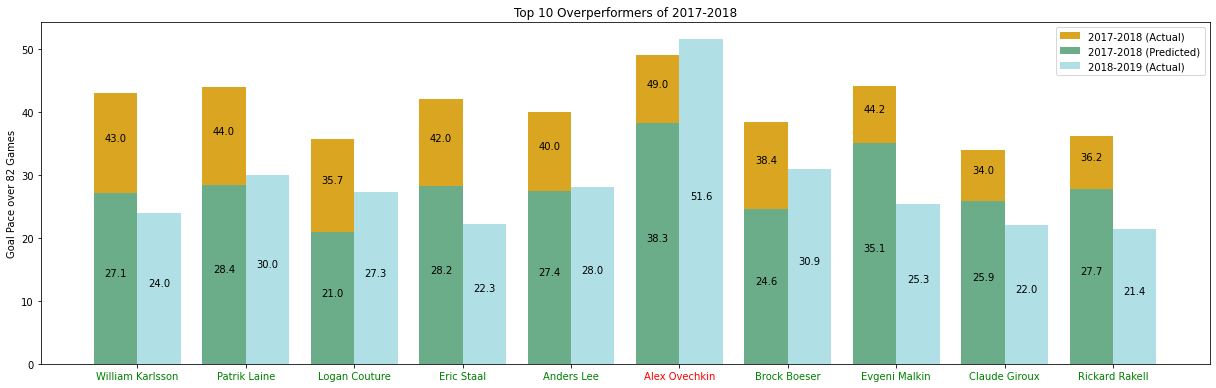

In [331]:
Find(OverPerformer, X_this_season, X_next_season, pd.DataFrame(y_this_season), pd.DataFrame(y_next_season), sr_ridge, print_details=False)



-----------------------------------
Top 10 Underperformers in 2017-2018


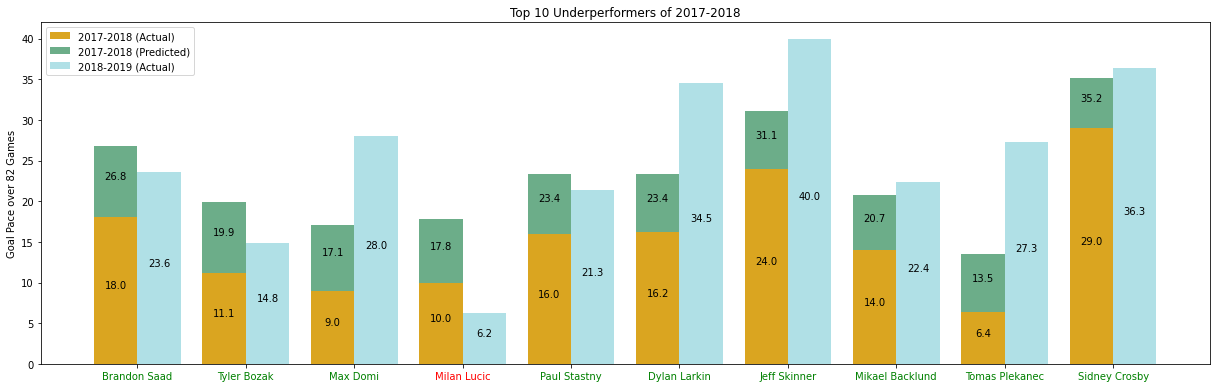

In [332]:
Find(UnderPerformer, X_this_season, X_next_season, pd.DataFrame(y_this_season), pd.DataFrame(y_next_season), sr_ridge, print_details=False)

In both cases, the model successfully predicted 9 out of 10 overperformers and underperformers.

## Quantitative Model Comparison (Work In Progress)

We have several models (Ridge, Lasso, Random Forest Regression) which are trained to predicted the number of goals a player scored. 

Now, let's use each of these models to make a new stacking model (final estimator Ridge) which essentially takes a weighted average "vote" between the existing models to predict goals. The new ensemble will train not by rewarding the models that most accurately predict goals, but by rewarding the models which best predict over/underperformers. 

This means we will need to mathematically quantify how well a model predicts under/overperformers. Define $y^0$ to be the goals scored last year, and $y^1$ to be the goals scored this year. Let $p = y^0 - y^0_\text{pred}$ be the vector difference between the actual goals scored last year and the predicted goals scored last year. 

Let's defined a model's **outlier predictive ability score** $\phi$ to be

\begin{equation}
\phi = \frac{1}{1+e^{-\frac{N}{|J|}}} \sum_{j \in J} D_j,
\end{equation}

where 
- $D = y^0 - y^1$ is the vector difference between goals scored last year $y^0$ and goals scored this year $y^1$
- $J = \{j : |p_j-\mu_p|\geq \sigma_p\}$, i.e. the set of indices $j$ for which $p_j$ is at least two standard deviations from the mean of $p$.
- $N$ is the number of correct predictions out of the $|J|$ predictions made by the model, where a "correct" prediction $j$ is defined as correctly predicting whether the player $j$ bounces back or regresses next season by at least half of the gap $p_j$.

The idea is that the score $\phi$ is higher when the differences $D_j$ in goals from one year to the next are large, but is slightly decreased by the sigmoid $(1+e^{-N/|J|})^{-1}$ when the model makes incorrect predictions.

Now we will create the Ridge ensemble model, and use GridSearchCV to find the best hyperparameter which maximizes the score $\mu$.

In [333]:
p = np.ravel(y_17_18) - np.ravel(pipe_Lasso.predict(X_17_18))

def Phi(N, J, D):
    return 1 / (1 + np.exp(-N/J)) * np.sum(D)

sigma_p = np.std(p)
print("The standard deviation of p is", sigma_p)
print("\nThe gaps above 2*sigma_p are:\n")
for gap in p:
    if gap > 2*sigma_p:
        print(gap)

The standard deviation of p is 2.9002597558787078

The gaps above 2*sigma_p are:

7.524425540205399
6.050359716736427
15.272779916196214
7.067208965465426
13.75060546878338
6.194179915205078
6.782625171014864
17.153042721339062
11.097279405888106
7.958416582470296
7.187400910231993
6.250238439548902
8.661518442422881
7.172390137728594
5.908918675958148
12.296261393944324
12.5091659779123
6.04833073082624
7.875848733656088
6.114419045165391
6.094307232922126
15.252018263922814
13.913701562024002
8.99856994269874
8.38391005844072
8.232972507091883
7.700625506984686
7.213086115488416
9.06223872384697
6.153913970842659
7.6452040699514825
6.91355454581198
6.963305968766921
